In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : ZReV67mr 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

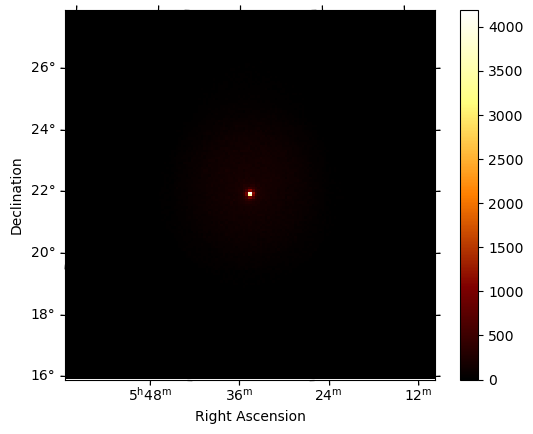

In [3]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]

dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'

shift = 0.1
tilt = 0.015


In [5]:
# here fluxpoints do not have any sys
# but we assume there is some, therfore set into inv covmatrix
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix





In [6]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(dataset_asimov)


CPU times: user 2.17 s, sys: 50.8 ms, total: 2.22 s
Wall time: 2.23 s


In [7]:
%%time
fit_N = Fit(store_trace=False)
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run(dataset_asimov_N)


CPU times: user 1min 1s, sys: 5.5 s, total: 1min 6s
Wall time: 1min 6s


In [8]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [9]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

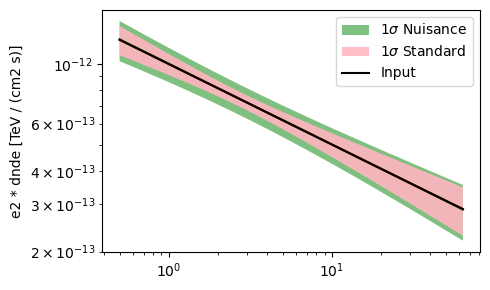

In [10]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red", alpha = 0.9)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "lightpink",
                                                   alpha = 0.9)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [11]:
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([dataset_asimov])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits", )
    


0.10000000000000002 TeV 0.1333521432163324 TeV
norm 1.0 0

0.1333521432163324 TeV 0.1778279410038923 TeV
norm 1.0 0

0.1778279410038923 TeV 0.23713737056616552 TeV
norm 1.0 0

0.23713737056616552 TeV 0.316227766016838 TeV
norm 1.0 0

0.316227766016838 TeV 0.4216965034285822 TeV
norm 1.0 0

0.4216965034285822 TeV 0.5623413251903491 TeV
norm 1.0000013336806377 1.0586191660392466

0.5623413251903491 TeV 0.7498942093324559 TeV
norm 1.0 0.4087195309866947

0.7498942093324559 TeV 1.0 TeV
norm 1.0000005978728883 0.2087431323602434

1.0 TeV 1.333521432163324 TeV
norm 1.0 0.17972413524291025

1.333521432163324 TeV 1.778279410038923 TeV
norm 1.0 0.18051636925445522

1.778279410038923 TeV 2.371373705661655 TeV
norm 1.0 0.18695986515703514

2.371373705661655 TeV 3.1622776601683795 TeV
norm 1.0 0.19948198865267874

3.1622776601683795 TeV 4.216965034285822 TeV
norm 1.0 0.21713187836756986

4.216965034285822 TeV 5.62341325190349 TeV
norm 1.0 0.23553368850697518

5.62341325190349 TeV 7.49894209332455

ifn flux:
models = Models(datasets.models.copy())

model = self.get_scale_model(models)

energy_min, energy_max = datasets.energy_ranges
energy_axis = MapAxis.from_energy_edges([energy_min.min(), energy_max.max()])

with np.errstate(invalid="ignore", divide="ignore"):
    result = model.reference_fluxes(energy_axis=energy_axis)
    # convert to scalar values
    result = {key: value.item() for key, value in result.items()}

models[self.source].spectral_model = model
datasets.models = models
result.update(super().run(datasets, model.norm))

In [13]:
dataset_asimov_N.geoms['geom'].axes[0].center.value

array([ 0.1154782 ,  0.15399265,  0.2053525 ,  0.27384196,  0.36517413,
        0.48696753,  0.64938163,  0.86596432,  1.15478198,  1.53992653,
        2.05352503,  2.73841963,  3.65174127,  4.86967525,  6.49381632,
        8.65964323, 11.54781985, 15.39926526, 20.53525026, 27.38419634,
       36.51741273, 48.69675252, 64.93816316, 86.59643234])

In [14]:
%%time
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    with dataset_asimov_N.models.restore_status():
        dataset_asimov_N.models.parameters.freeze_all()
        dataset_asimov_N.models.parameters['norm_nuisance'].frozen = False
        #think abou t freezing the tilt nuisance here...
        dataset_asimov_N.models.parameters['tilt_nuisance'].frozen = False
        fluxpoints_asimov_N = esti_N.run(dataset_asimov_N)

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)
    


0.10000000000000002 TeV 0.1333521432163324 TeV
norm 1.0 0
norm_nuisance -7.628148885332292e-05 0.10867086704251451
tilt_nuisance 3.0012842732196403e-06 0.014910764202297528
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error

0.1333521432163324 TeV 0.1778279410038923 TeV
norm 1.0 0
norm_nuisance -7.628148885332292e-05 0.10867086704251451
tilt_nuisance 3.0012842732196403e-06 0.014910764202297528
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error

0.1778279410038923 TeV 0.23713737056616552 TeV
norm 1.0 0
norm_nuisance -7.628148885332292e-05 0.10867086704251451
tilt_nuisance 3.0012842732196403e-06 0.014910764202297528
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error

0.23713737056616552 TeV 0.316227766016838 TeV
norm 1.0 0
norm_nuisance -7.628148885332292e-05 0.10867086704251451
tilt_nuisance 3.0012842732196403e-06 0.014910764202297528
bias 0

In [14]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

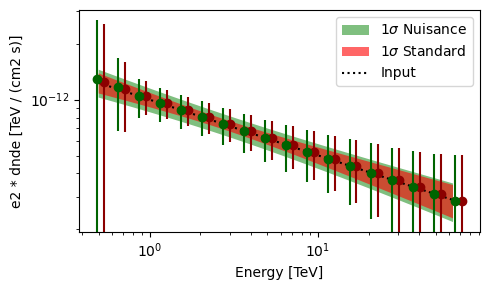

In [15]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
